## Standalone LSTM Encoder - Decoder Model
In this model, we first create an LSTM-based encoder-decoder model and then extract out the standalone encoder.  Recurrent neural networks, such as a long short-term memory (LSTM) networks, are specifically designed to model sequences of input data.  In this neural network architecture, the encoder reads the input sequence time step, by time step. After digesting the entire time step sequence, it's output, or hidden state, is a compressed representation of the input sequence as a fixed length vector.  The vector is then provided as input to the decoder which interprets each time step of the output sequence as its generated.

Once a satisfactory encoder-decoder model has been created, one that accurately depicts the reconstruction of the input sequence, we can separate the encoder model as a standalone model.  The standalone encoder will contain only those layers up to creation of the fixed length vector. The encoder model can then be used as a learned, compressed representation of the input features to feed into other models.  

Here we take a multivariate sequence containing six numbers per time step (6 features per time step) and feed the LSTM model a block of 12 time steps at once for analysis.  We use a batch size of 20.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random as rn
import tensorflow as tf
from tensorflow import set_random_seed
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, RepeatVector
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from keras.optimizers import Adam, RMSprop

Using TensorFlow backend.


In [2]:
# set the random seed
tf.logging.set_verbosity(tf.logging.ERROR)
sd = 777
np.random.seed(sd)
rn.seed(sd)
set_random_seed(sd)

In [3]:
# load dataset
series = pd.read_csv('data/sequence.csv', engine='python', header=None)
series.head(10)

,0,1,2,3,4,5
0,3,15,20,21,36,40
1,7,18,28,35,38,42
2,12,22,23,26,27,43
3,14,19,23,34,36,41
4,11,12,20,30,32,44
5,8,13,19,28,39,41
6,2,10,22,24,27,41
7,18,20,23,25,35,39
8,8,15,24,36,38,40
9,6,21,26,27,33,39


In [4]:
# drop columns if needed
df = series.drop([], axis=1)
print("Dataset length:", len(df))
df.head(10)

Dataset length: 2156


,0,1,2,3,4,5
0,3,15,20,21,36,40
1,7,18,28,35,38,42
2,12,22,23,26,27,43
3,14,19,23,34,36,41
4,11,12,20,30,32,44
5,8,13,19,28,39,41
6,2,10,22,24,27,41
7,18,20,23,25,35,39
8,8,15,24,36,38,40
9,6,21,26,27,33,39


In [5]:
# extract the values
data = df.values
data = data.astype('float64')

In [6]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
print("The scaled dataset shape is: " + str(data_scaled.shape))
print(data_scaled)

The scaled dataset shape is: (2156, 6)
[[0.07142857 0.38235294 0.44736842 0.44736842 0.80555556 0.86666667]
 [0.21428571 0.47058824 0.65789474 0.81578947 0.86111111 0.93333333]
 [0.39285714 0.58823529 0.52631579 0.57894737 0.55555556 0.96666667]
 ...
 [0.14285714 0.32352941 0.44736842 0.86842105 0.86111111 0.86666667]
 [0.14285714 0.41176471 0.44736842 0.63157895 0.63888889 0.93333333]
 [0.         0.         0.10526316 0.15789474 0.44444444 0.33333333]]


In [7]:
def reverse_scale_predictions(scaler, input_set):
    scaled_set, temp = list(), list()
    for i in range(len(input_set)):
        row = input_set[i]
        row = np.reshape(row, (input_set.shape[1], input_set.shape[2]))       
        out = scaler.inverse_transform(row)
        out2 = np.around(out).astype(int)
        temp.append(out2)
    temp2 = np.array(temp).tolist()
    while temp2:
        scaled_set.extend(temp2.pop(0))
    return scaled_set  

In [8]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [9]:
# create features and targets
n_steps = 12
X, y = split_sequences(data_scaled, n_steps)
print("Input shape: " + str(X.shape))
print("Target shape: " + str(y.shape))

Input shape: (2144, 12, 6)
Target shape: (2144, 6)


In [10]:
# modify for batch sizing
X = X[4:]
y = y[4:]
print("Revised input shape: " + str(X.shape))
print("Revised target shape: " + str(y.shape))

Revised input shape: (2140, 12, 6)
Revised target shape: (2140, 6)


In [11]:
# define the Autoencoder model
def autoencoder_model(X, batch_size):
    inputs = Input(batch_shape=(batch_size, X.shape[1], X.shape[2]))
    enc1 = LSTM(512, activation='relu', return_sequences=True)(inputs)
    enc2 = LSTM(256, activation='relu', return_sequences=True)(enc1)
    enc3 = LSTM(128, activation='relu', return_sequences=False)(enc2)
    dec1 = RepeatVector(X.shape[1])(enc3)
    dec2 = LSTM(128, activation='relu', return_sequences=True)(dec1)
    dec3 = LSTM(256, activation='relu', return_sequences=True)(dec2)
    dec4 = LSTM(512, activation='relu', return_sequences=True)(dec3)         
    output = TimeDistributed(Dense(X.shape[2]))(dec4)
    model = Model(inputs=inputs, outputs=output)
    return model 

In [12]:
# create the LSTM Autoencoder model
batch_size = 20
autoencoder = autoencoder_model(X, batch_size)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (20, 12, 6)               0         
_________________________________________________________________
lstm_1 (LSTM)                (20, 12, 512)             1062912   
_________________________________________________________________
lstm_2 (LSTM)                (20, 12, 256)             787456    
_________________________________________________________________
lstm_3 (LSTM)                (20, 128)                 197120    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (20, 12, 128)             0         
_________________________________________________________________
lstm_4 (LSTM)                (20, 12, 128)             131584    
_________________________________________________________________
lstm_5 (LSTM)                (20, 12, 256)             394240    
__________

In [13]:
# fit the model
nb_epochs = 1000
history = autoencoder.fit(X, X, epochs=nb_epochs, batch_size=batch_size).history

Epoch 1/1000
2140/2140 [==============================] - 35s 17ms/step - loss: 0.0821
Epoch 2/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 0.0329
Epoch 3/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 0.0323
Epoch 4/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 0.0317
Epoch 5/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 0.0313
Epoch 6/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 0.0310
Epoch 7/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 0.0307
Epoch 8/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 0.0300
Epoch 9/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 0.0291
Epoch 10/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 0.0291
Epoch 11/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 0.0282
Epoch 12/1000
2140/2140 [================

2140/2140 [==============================] - 35s 16ms/step - loss: 4.5045e-04
Epoch 185/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 4.9992e-04
Epoch 186/1000
2140/2140 [==============================] - 36s 17ms/step - loss: 5.0547e-04
Epoch 187/1000
2140/2140 [==============================] - 36s 17ms/step - loss: 5.4580e-04
Epoch 188/1000
2140/2140 [==============================] - 34s 16ms/step - loss: 4.7532e-04
Epoch 189/1000
2140/2140 [==============================] - 33s 16ms/step - loss: 4.2440e-04
Epoch 190/1000
2140/2140 [==============================] - 33s 15ms/step - loss: 4.6262e-04
Epoch 191/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 5.2770e-04
Epoch 192/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 5.4995e-04
Epoch 193/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 4.7874e-04
Epoch 194/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 3.8

2140/2140 [==============================] - 38s 18ms/step - loss: 1.4894e-04
Epoch 361/1000
2140/2140 [==============================] - 34s 16ms/step - loss: 1.3495e-04
Epoch 362/1000
2140/2140 [==============================] - 37s 17ms/step - loss: 1.3364e-04
Epoch 363/1000
2140/2140 [==============================] - 41s 19ms/step - loss: 1.4985e-04
Epoch 364/1000
2140/2140 [==============================] - 39s 18ms/step - loss: 1.9388e-04
Epoch 365/1000
2140/2140 [==============================] - 35s 16ms/step - loss: 2.4102e-04
Epoch 366/1000
2140/2140 [==============================] - 37s 17ms/step - loss: 2.3922e-04
Epoch 367/1000
2140/2140 [==============================] - 36s 17ms/step - loss: 2.1828e-04
Epoch 368/1000
2140/2140 [==============================] - 36s 17ms/step - loss: 1.8350e-04
Epoch 369/1000
2140/2140 [==============================] - 34s 16ms/step - loss: 1.5753e-04
Epoch 370/1000
2140/2140 [==============================] - 35s 16ms/step - loss: 1.4

2140/2140 [==============================] - 31s 15ms/step - loss: 1.6571e-04
Epoch 537/1000
2140/2140 [==============================] - 31s 15ms/step - loss: 1.2408e-04
Epoch 538/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 9.7946e-05
Epoch 539/1000
2140/2140 [==============================] - 31s 14ms/step - loss: 7.3676e-05
Epoch 540/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 5.9883e-05
Epoch 541/1000
2140/2140 [==============================] - 31s 14ms/step - loss: 5.5591e-05
Epoch 542/1000
2140/2140 [==============================] - 33s 15ms/step - loss: 4.9232e-05
Epoch 543/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 5.0762e-05
Epoch 544/1000
2140/2140 [==============================] - 33s 15ms/step - loss: 4.9252e-05
Epoch 545/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 6.5866e-05
Epoch 546/1000
2140/2140 [==============================] - 31s 15ms/step - loss: 1.1

2140/2140 [==============================] - 35s 16ms/step - loss: 2.8440e-05
Epoch 713/1000
2140/2140 [==============================] - 35s 16ms/step - loss: 2.4646e-05
Epoch 714/1000
2140/2140 [==============================] - 34s 16ms/step - loss: 2.2665e-05
Epoch 715/1000
2140/2140 [==============================] - 34s 16ms/step - loss: 2.7107e-05
Epoch 716/1000
2140/2140 [==============================] - 35s 16ms/step - loss: 2.8550e-05
Epoch 717/1000
2140/2140 [==============================] - 37s 17ms/step - loss: 3.4870e-05
Epoch 718/1000
2140/2140 [==============================] - 32s 15ms/step - loss: 4.2810e-05
Epoch 719/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 7.4624e-05
Epoch 720/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 1.0264e-04
Epoch 721/1000
2140/2140 [==============================] - 31s 14ms/step - loss: 1.1832e-04
Epoch 722/1000
2140/2140 [==============================] - 36s 17ms/step - loss: 1.1

2140/2140 [==============================] - 30s 14ms/step - loss: 3.2515e-05
Epoch 889/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 4.6668e-05
Epoch 890/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 5.8332e-05
Epoch 891/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 1.1526e-04
Epoch 892/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 1.5594e-04
Epoch 893/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 1.4709e-04
Epoch 894/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 8.1630e-05
Epoch 895/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 4.4484e-05
Epoch 896/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 2.9219e-05
Epoch 897/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 2.1739e-05
Epoch 898/1000
2140/2140 [==============================] - 30s 14ms/step - loss: 1.7

In [14]:
# validate autoencoder
yhat = autoencoder.predict(X, batch_size)
baseline = reverse_scale_predictions(scaler, X)
predictions = reverse_scale_predictions(scaler, yhat)
for i in range(10):
    print("actual: %s, predicted: %s" % (baseline[i], predictions[i]))

actual: [11, 12, 20, 30, 32, 44], predicted: [11, 12, 20, 30, 32, 44]
actual: [8, 13, 19, 28, 39, 41], predicted: [8, 14, 19, 27, 39, 41]
actual: [2, 10, 22, 24, 27, 41], predicted: [2, 10, 22, 24, 27, 41]
actual: [18, 20, 23, 25, 35, 39], predicted: [18, 20, 23, 24, 34, 39]
actual: [8, 15, 24, 36, 38, 40], predicted: [8, 15, 24, 36, 38, 40]
actual: [6, 21, 26, 27, 33, 39], predicted: [6, 21, 26, 27, 32, 39]
actual: [11, 14, 15, 18, 21, 40], predicted: [11, 14, 15, 18, 21, 40]
actual: [12, 26, 27, 28, 33, 39], predicted: [12, 26, 27, 28, 33, 39]
actual: [6, 11, 14, 24, 27, 37], predicted: [6, 11, 14, 24, 27, 37]
actual: [19, 33, 37, 39, 41, 44], predicted: [19, 34, 37, 39, 41, 44]


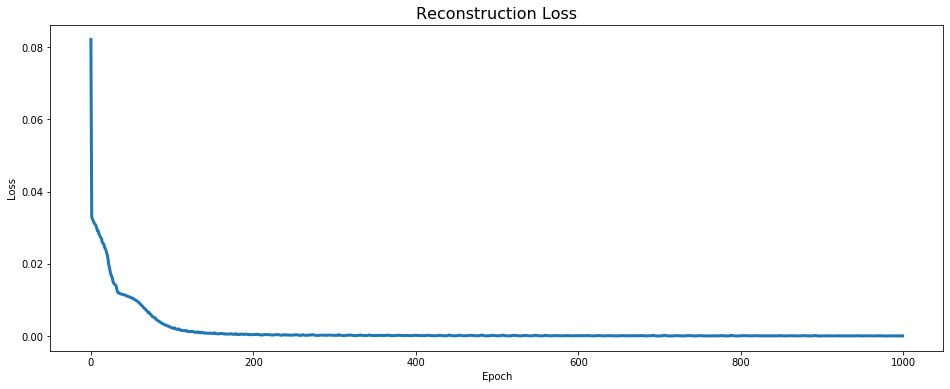

In [15]:
# plot the model loss
plt.figure(figsize=(16,6))
plt.plot(history['loss'], linewidth=3)
plt.title('Reconstruction Loss', fontsize=16)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [16]:
# create stand alone encoder
encoder = Model(inputs=autoencoder.inputs, outputs=autoencoder.layers[3].output)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (20, 12, 6)               0         
_________________________________________________________________
lstm_1 (LSTM)                (20, 12, 512)             1062912   
_________________________________________________________________
lstm_2 (LSTM)                (20, 12, 256)             787456    
_________________________________________________________________
lstm_3 (LSTM)                (20, 128)                 197120    
Total params: 2,047,488
Trainable params: 2,047,488
Non-trainable params: 0
_________________________________________________________________


In [18]:
# validate encoder output
encoder_output = encoder.predict(X, batch_size)
print("Encoder output shape:", encoder_output.shape)
print(encoder_output)

Encoder output shape: (2140, 128)
[[0.         0.01816534 0.         ... 0.01122764 0.         0.        ]
 [0.         0.0544333  0.         ... 0.01204368 0.         0.22154157]
 [0.         0.03412243 0.         ... 0.03304881 0.         0.        ]
 ...
 [0.         0.02169593 0.         ... 0.         0.         0.17469828]
 [0.         0.00356639 0.         ... 0.00160127 0.         0.07961552]
 [0.         0.5866183  0.         ... 0.01417389 0.         0.56231415]]


In [19]:
# spacer

In [20]:
# save model in YAML format and weights in HDF5
model_yaml = encoder.to_yaml()
with open("encoder_standalone_20x12x6.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
print("Model saved")
encoder.save_weights("encoder_standalone_20x12x6.hdf5")
print("Model weights saved")

Model saved
Model weights saved
